# Genre prediction from song lyrics

## The dataset

The data used for this project is made up of two different data sets, set #1: "artists-data.csv" and set #2: "lyrics-data.csv".

Set #1 is a data set that contains information about artists and their respective genres, how many songs they have produced and some information about popularity etc. It will be used with the artists name, the genre and the "link"-column, which will enable us to make a direct reference between the two data sets.

Set #2 contains information about specific songs, like song name, song lyrics, language and also the "link" column for the reference to the artists data set.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import spacy

### Artists data set:

First, we look at the artists data set.

We want to use the artists data set to find the respective artists genre for each song in the lyrics data set. We remove the unnecessary columns for preprocessing. The 'Link' column will be used to connect the song in the lyrics data set to the artists genres.

In [2]:
artists = pd.read_csv('artists-data.csv')
artists = artists.drop(['Popularity', 'Songs'], axis=1)
artists.head()

,Artist,Genres,Link
0,Ivete Sangalo,Pop; Axé; Romântico,/ivete-sangalo/
1,Chiclete com Banana,Axé,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,/banda-eva/
3,É O Tchan,Axé,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,/claudia-leitte/


### Lyrics data set:

For this project we will remove all songs that are not english, and then remove unnecessary columns.

In [3]:
lyrics = pd.read_csv('lyrics-data.csv')
lyrics = lyrics[lyrics['language'] == 'en'] # only want songs with english lyrics, 51% of the data set.
lyrics = lyrics.drop(['SLink', 'language'], axis=1) # remove unnecessary columns
lyrics = lyrics.reset_index() # reset the index
lyrics = lyrics.drop(['index'], axis=1)

In [4]:
lyrics.head()

,ALink,SName,Lyric
0,/ivete-sangalo/,Careless Whisper,I feel so unsure\nAs I take your hand and lead...
1,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school..."
2,/ivete-sangalo/,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c..."
3,/ivete-sangalo/,Easy,"Know it sounds funny\nBut, I just can't stand ..."
4,/ivete-sangalo/,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...


We now want to create the new and "final" data set from the lyrics data set by combining every entry with its corresponding genre by extracting it from the artists data set.

We can then pick out the 20 most frequent genres and look only at those, partly to decrease the amount of data, but also since we are not interested in being too specific with the classification, and we can expect genres such as "pop", "rock", "rap" etc. to be the most frequent anyway.

In [5]:
#merging 'Genre' from 'artists' into 'lyrics'
data = lyrics.merge(artists[['Link', 'Genres']], left_on='ALink', right_on='Link', how='left')

#dropping the 'Link' column from 'artists' as it's no longer needed
data.drop(['Link', 'ALink'], axis=1, inplace=True)

data['Genres'].value_counts()[0:20]

Genres
Country                         4774
Rock                            4672
Heavy Metal                     4394
Indie                           4289
Rap; Hip Hop                    3426
Pop                             2544
Hip Hop; Rap; Black Music       2456
Rock; Hard Rock; Heavy Metal    2130
Rap                             2012
Heavy Metal; Rock; Hard Rock    1781
Hip Hop; Rap                    1657
Heavy Metal; Hard Rock; Rock    1507
Indie; Rock                     1502
Soul Music; R&B                 1485
Gospel/Religioso                1431
Pop/Rock                        1374
Jazz                            1356
Punk Rock                       1310
Rap; Hip Hop; Black Music       1293
Reggae                          1255
Name: count, dtype: int64

In [6]:
#extract the data for the 20 most frequent genres
data = data[data['Genres'].isin(data['Genres'].value_counts()[0:21].index)]
data.shape
##about 48.000 entries

(47760, 3)

Since some artists have more than one genre, it would be interesting to treat that as a separate entry, to get a better understanding of how the genres are distributed. We do some processing of the genres and compare it to the data where artists have several genres:

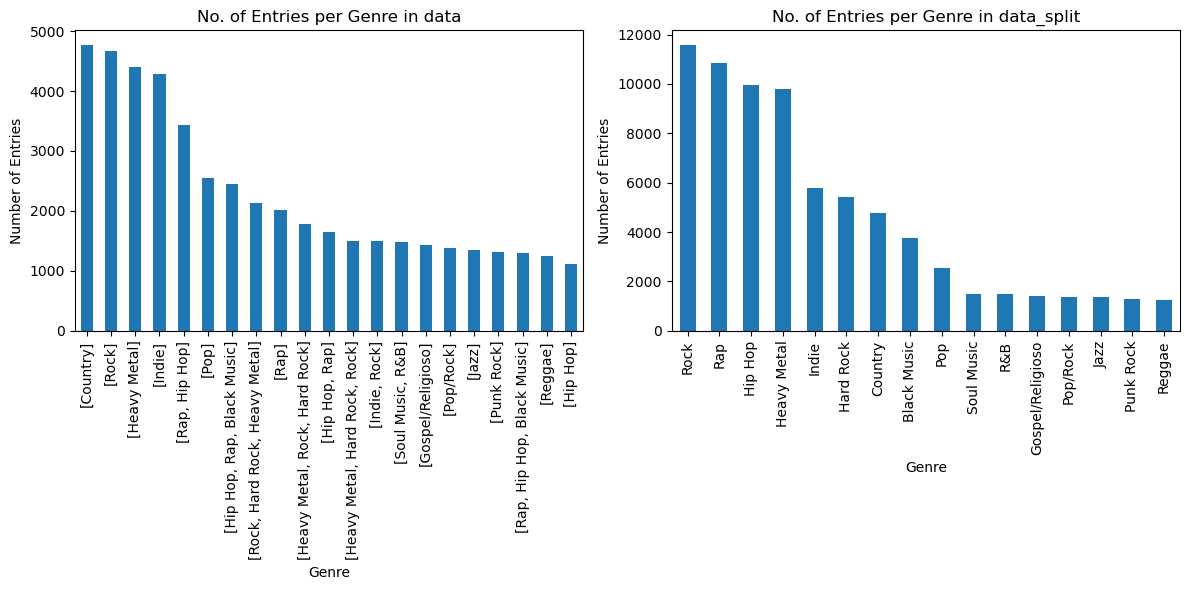

In [7]:
#turn genres into lists and remove whitespace in front of and after each genre
data['Genres'] = data['Genres'].apply(lambda x: [item.strip() for item in x.split(';')])
#create one row for each genre an artist have been labelled as
data_split = data.explode('Genres')
#plot the top 20 genres to see 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

#plot for 'artists' DataFrame
data['Genres'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('No. of Entries per Genre in data')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Number of Entries')

#plot for 'artists_split' DataFrame
data_split['Genres'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('No. of Entries per Genre in data_split')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Number of Entries')

plt.tight_layout()
plt.show()

Splitting the different genres and representing them as separate entries looks better, but we still have "Pop/Rock" and "Gospel/Religioso". We can fix that aswell. The genres list contains all the "normal" genres that any other of the genres could fit into. If any genre in the data contains that word, for example "Hard rock" contains "rock", then that should be assigned to "Rock".

In [8]:
genres = ['rock', 'rap', 'hip hop', 'metal', 'indie', 'country', 'black music', 'pop', 'soul', 'R&B', 'gospel', 'jazz', 'reggae']

def find_genre(entry):
    for genre in genres:
        if genre in entry.lower():
            return genre
    return entry  # If no genre is found, return the original entry

data_split['Genres'] = data_split['Genres'].apply(find_genre)

<Axes: xlabel='Genres'>

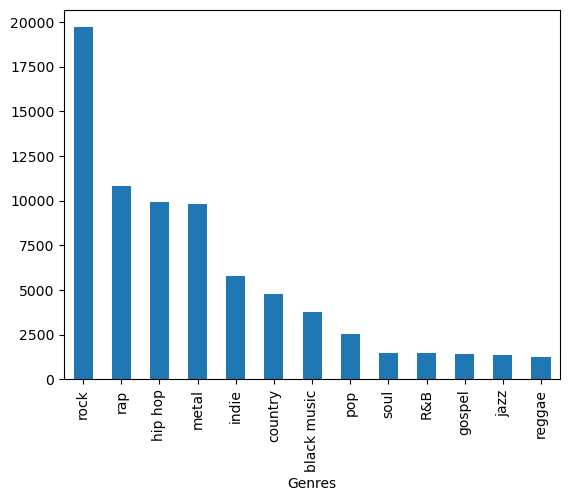

In [9]:
data_split['Genres'].value_counts().plot(kind='bar')

In [10]:
#looking at distribution of genres by percentage
genre_counts = data_split['Genres'].value_counts()
genre_percentages = (genre_counts / len(data_split)) * 100

print(genre_percentages)

Genres
rock           26.554663
rap            14.621649
hip hop        13.408123
metal          13.230139
indie           7.808371
country         6.437085
black music     5.055013
pop             3.430236
soul            2.002319
R&B             2.002319
gospel          1.929508
jazz            1.828380
reggae          1.692196
Name: count, dtype: float64


This looks better, but now we can see that the data is pretty unbalanced, as ~ 26,5% of the songs are now labelled as "rock", which is understandable after the changes we have made to the classes.

If we continue with this data set, we will not be able to use accuracy as a good evaluation of the model, since the unbalanced data will not give a fair view of the models performance, since for example it could statistically have 26,5% accuracy from only guessing "rock" every time.

We could ignore this and still go on to train our model, our we could do some over- or undersampling to balance the data. In our case, we can settle for another method to use before we balance the data using over- or undersampling.

Removing duplicates, this will make sure that every song only occurs once in the data, and the first entry of that song will be chosen with its corresponding genre. This is necessary after we did the splitting of the different genres. Since the duplicate genres often were similar and in random order, this would give us a good data set in the end.

<Axes: xlabel='Genres'>

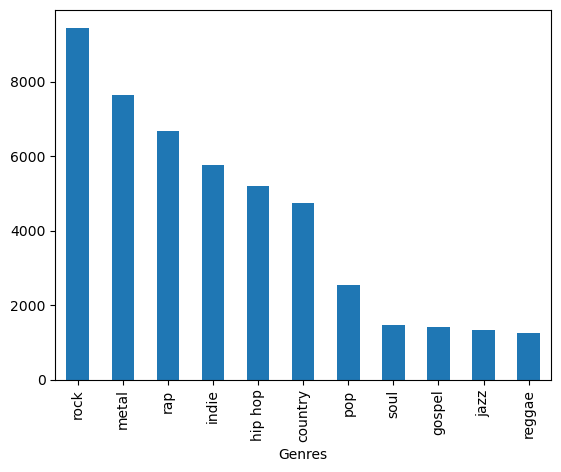

In [80]:
data_split.head()

data_final = data_split.drop_duplicates(subset=['Lyric'])

genre_counts_final = data_final['Genres'].value_counts()
genre_percentages_final = (genre_counts_final / len(data_final)) * 100

#print(genre_percentages_final)

data_final['Genres'].value_counts().plot(kind='bar')
genre_percentages_final.plot(kind='bar')

We got a better distribution of the classes now without having to do over/undersampling. We can still expect the model to classify songs as rock more often than reggae, but we can now expect that.

Now we split the data into 80% training and 20% test data.

In [12]:
train_data, test_data = train_test_split(data_final, test_size=0.2, random_state=1)


train_data.shape[0] / data_final.shape[0], test_data.shape[0] / data_final.shape[0]

(0.7999873729402108, 0.20001262705978912)

## Stopwords

A list of stopwords from the link below. Added some words that are found in most song lyrics that hold little meaning.

In [53]:
#https://gist.github.com/rg089/35e00abf8941d72d419224cfd5b5925d

import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = list(stopwords_list.decode().splitlines())
stopwords.append('gonna')
stopwords.append('yeah')
stopwords.append('baby')
stopwords.append('love')
stopwords.append('chorus')

## Baseline

By constructing a baseline with a dummy classifier, we can use the performance of that model to determine if our models are performing well or not.

In [39]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

In [41]:
dummy_clf = DummyClassifier(strategy='stratified') # stratified to account for the actual distribution of the data.
dummy_clf.fit(train_data['Lyric'], train_data['Genres'])

dummy_true = test_data['Genres']
dummy_pred = dummy_clf.predict(test_data['Lyric'])

print(classification_report(dummy_true, dummy_pred))

              precision    recall  f1-score   support

     country       0.11      0.10      0.11      1002
      gospel       0.02      0.02      0.02       265
     hip hop       0.12      0.12      0.12      1038
       indie       0.11      0.11      0.11      1101
        jazz       0.03      0.03      0.03       293
       metal       0.16      0.16      0.16      1551
         pop       0.07      0.07      0.07       509
         rap       0.14      0.14      0.14      1322
      reggae       0.02      0.02      0.02       249
        rock       0.18      0.18      0.18      1864
        soul       0.03      0.03      0.03       310

    accuracy                           0.13      9504
   macro avg       0.09      0.09      0.09      9504
weighted avg       0.13      0.13      0.13      9504



### Conclusion:

With stratified strategy, where the actual distribution of the data in the data set is taken into account, we get an accuracy of 13%, weighted avg. precision of 13%, weighted avg recall of 13%  and a weighted avg. f1-score of 13%.

## Model selection

In [94]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [98]:
%%time
pipe = make_pipeline(CountVectorizer(stop_words=stopwords), MultinomialNB())
pipe.fit(train_data['Lyric'], train_data['Genres']) # Fit to training data

true = test_data['Genres']
pred = pipe.predict(test_data['Lyric'])

print(classification_report(true, pred))

/Users/rickard/miniforge3/envs/liu-text-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

     country       0.55      0.54      0.54      1002
      gospel       0.69      0.40      0.51       265
     hip hop       0.69      0.60      0.64      1038
       indie       0.60      0.30      0.40      1101
        jazz       0.70      0.13      0.22       293
       metal       0.65      0.75      0.69      1551
         pop       0.45      0.20      0.28       509
         rap       0.67      0.80      0.73      1322
      reggae       0.84      0.39      0.53       249
        rock       0.38      0.64      0.47      1864
        soul       0.44      0.03      0.05       310

    accuracy                           0.55      9504
   macro avg       0.61      0.43      0.46      9504
weighted avg       0.58      0.55      0.53      9504

CPU times: user 10 s, sys: 237 ms, total: 10.3 s
Wall time: 11.7 s


#### Model comparison:

| Model                | Accuracy | Precision (weighted avg) | Recall (weighted avg) | F1-Score (weighted avg) |
|----------------------|----------|--------------------------|-----------------------|-------------------------|
| Baseline             | 13%      | 13%                      | 13%                   | 13%                     |
| Naive Bayes          | 55%      | 58%                      | 55%                   | 53%                     |
| Decision Tree        | 40%      | 40%                      | 40%                   | 40%                     |
| KNeighbors Classifier| 24%      | 29%                      | 24%                   | 23%                     |

Continuing with Naive bayes as it has the best performance of the three models. It provides the highest overall accuracy, a good precision and a good recall, resulting in a good f-score. We can look at the results from the NB model by analyzing its confusion matrix.

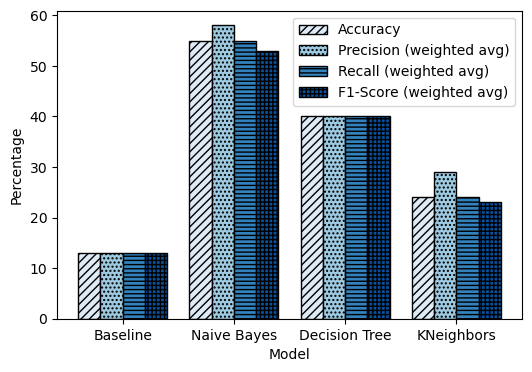

In [100]:
# Adjusting to a more accurate blue color palette
patterns = ['////', '....', '----', '++++'] 
# Defining a more accurate blue color palette
blue_colors = ['#deebf7', '#9ecae1', '#3182bd', '#08519c']  # More accurate shades of blue

# Make the plot
plt.figure(figsize=(6,4))
plt.bar(r1, accuracy, hatch=patterns[0], color=blue_colors[0], edgecolor='black', width=0.2, label='Accuracy')
plt.bar(r2, precision, hatch=patterns[1], color=blue_colors[1], edgecolor='black', width=0.2, label='Precision (weighted avg)')
plt.bar(r3, recall, hatch=patterns[2], color=blue_colors[2], edgecolor='black', width=0.2, label='Recall (weighted avg)')
plt.bar(r4, f1_score, hatch=patterns[3], color=blue_colors[3], edgecolor='black', width=0.2, label='F1-Score (weighted avg)')

# Add xticks on the middle of the group bars
plt.xlabel('Model')
plt.ylabel('Percentage')
plt.xticks([r + 0.3 for r in range(len(models))], models)


# Create legend & Show graphic
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

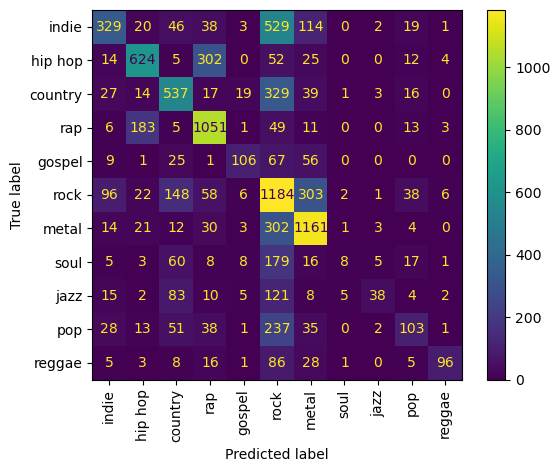

In [55]:
# Compute Confusion Matrix
cm = confusion_matrix(true, pred, labels = true.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=true.unique())

# Plot
disp.plot()
plt.xticks(rotation=90)

plt.show()

## Conclusions on Multinomial Naive Bayes:

We can see that the model is best at classifying rock, rap and metal. The model does mix rock and metal up a lot of times. This makes sense considering that metal comes from rock music, and that the genres generally shares themes, and in some ways we could argue that they have the same stylistic directions.

Rap and Hip Hop is often confused with one another, which also makes sense due to the genres being similar in lyrical style, and hip hop often contains a lot of rap.

Overall, the model often wrongly classifies most genres as rock, and this is probably due to the unbalanced data set.


## Balancing the dataset

We can now try to balance the data set using different methods, over- and undersampling, and a combination of the two to see which one performs best.

## Undersampling

We perform undersampling on all classes to match the amount of entries in the minority class, and then train the model again on the new balanced training data.

In [19]:
import numpy as np
from sklearn.utils import shuffle

In [56]:
quota = np.min(train_data['Genres'].value_counts())

genres = train_data['Genres'].unique()

undersampled_data = [train_data.get(train_data['Genres'] == genre).sample(n=quota, random_state=1) for genre in genres]
undersampled_data = shuffle(pd.concat(undersampled_data))


undersampled_lyrics = undersampled_data['Lyric']
undersampled_genres = undersampled_data['Genres']


undersampled_pipe = make_pipeline(CountVectorizer(stop_words=stopwords), MultinomialNB())
undersampled_pipe.fit(undersampled_lyrics, undersampled_genres)

undersampled_true = test_data['Genres']
undersampled_pred = undersampled_pipe.predict(test_data['Lyric'])

print(classification_report(undersampled_true, undersampled_pred))

/Users/rickard/miniforge3/envs/liu-text-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

     country       0.48      0.47      0.47      1002
      gospel       0.41      0.72      0.53       265
     hip hop       0.55      0.64      0.59      1038
       indie       0.57      0.23      0.33      1101
        jazz       0.48      0.44      0.46       293
       metal       0.68      0.69      0.68      1551
         pop       0.20      0.59      0.30       509
         rap       0.63      0.67      0.65      1322
      reggae       0.52      0.65      0.58       249
        rock       0.45      0.20      0.28      1864
        soul       0.22      0.35      0.27       310

    accuracy                           0.49      9504
   macro avg       0.47      0.52      0.47      9504
weighted avg       0.52      0.49      0.48      9504



In this case, we got worse results than when training the model on the unbalanced dataset, and received an accuracy of 47%. This could be due to the training data set now being much smaller, and since we undersampled and removed a lot of entries in the original data set, data have been lost in the process. The recall was better with this data, meaning that it is better at finding the classes, but at the cost of the precision. This could potentially mean that the model is better at generalizing

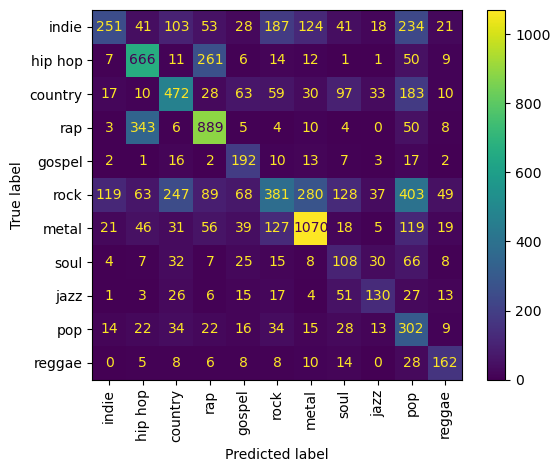

In [57]:
cm = confusion_matrix(undersampled_true, undersampled_pred, labels = true.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=true.unique())

# Plot
disp.plot()
plt.xticks(rotation=90)
plt.show()

## Oversampling

In [76]:
quota = np.max(train_data['Genres'].value_counts())

genres = train_data['Genres'].unique()

oversampled_data = [train_data.get(train_data['Genres'] == genre).sample(n=quota, replace=True, random_state=1) for genre in genres]
oversampled_data = shuffle(pd.concat(oversampled_data))

# Take out features and labels from oversampled data
oversampled_lyrics = oversampled_data['Lyric']
oversampled_genres = oversampled_data['Genres']


oversampled_pipe = make_pipeline(CountVectorizer(stop_words=stopwords), MultinomialNB())
oversampled_pipe.fit(oversampled_lyrics, oversampled_genres)

oversampled_true = test_data['Genres']
oversampled_pred = oversampled_pipe.predict(test_data['Lyric'])

print(classification_report(oversampled_true, oversampled_pred))

/Users/rickard/miniforge3/envs/liu-text-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

     country       0.52      0.58      0.55      1002
      gospel       0.46      0.69      0.55       265
     hip hop       0.65      0.65      0.65      1038
       indie       0.56      0.43      0.49      1101
        jazz       0.48      0.48      0.48       293
       metal       0.69      0.74      0.71      1551
         pop       0.27      0.51      0.36       509
         rap       0.71      0.72      0.72      1322
      reggae       0.66      0.62      0.64       249
        rock       0.48      0.30      0.37      1864
        soul       0.24      0.33      0.28       310

    accuracy                           0.55      9504
   macro avg       0.52      0.55      0.53      9504
weighted avg       0.56      0.55      0.55      9504



Using an oversampling strategy, by random duplication of entries in the minority classes, we get an accuracy of 55%, weighted avg for f1-score 55%. If we look at the precision and f1-score, we see that the model is good at predicting metal, rap and reggae. With a balanced data set, this makes sense, as often times metal, rap and reggae music tend to use themes in their lyrics that are more iconic for those genres.

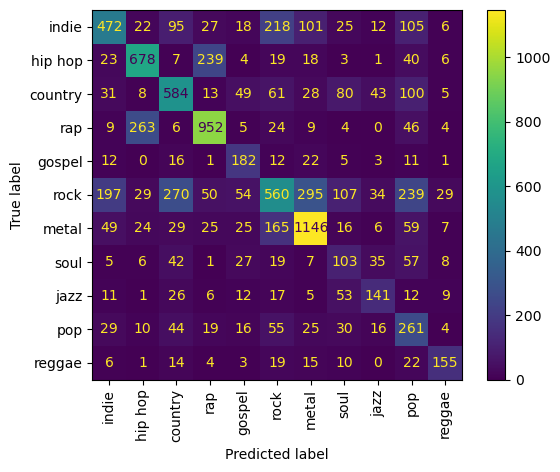

In [59]:
cm = confusion_matrix(oversampled_true, oversampled_pred, labels = true.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=true.unique())

# Plot
disp.plot()
plt.xticks(rotation=90)
plt.show()

## Combined over- and undersampling:

Lastly, we can try to combine oversampling and undersampling. We can choose the median class as our quota, and then perform oversampling on the classes that have less entries than the median, and perform undersampling on those that have more entries.

With Country as our median class, we get the following:

In [60]:
quota = train_data[train_data['Genres'] == 'country'].shape[0]

## Undersampling the larger classes:

genre_counts = train_data['Genres'].value_counts()
larger_genres = genre_counts[genre_counts > quota]

undersampling_lst = train_data[train_data['Genres'].isin(larger_genres)]

us_genres = larger_genres.index.tolist()

us_data = [train_data.get(train_data['Genres'] == genre).sample(n=quota, random_state=1) for genre in us_genres]

us_data = shuffle(pd.concat(us_data))

## Now oversampling the smaller classes:

smaller_genres = genre_counts[genre_counts < quota]

oversampling_lst = train_data[train_data['Genres'].isin(smaller_genres)]

os_genres = smaller_genres.index.tolist()

os_data = [train_data.get(train_data['Genres'] == genre).sample(n=quota, replace=True, random_state=1) for genre in os_genres]
os_data = shuffle(pd.concat(os_data))


## Combining them into a balanced data set:

combined_data = shuffle(pd.concat([us_data, train_data[train_data['Genres'] == 'country'], os_data]))
combined_data['Genres'].value_counts()



combined_lyrics = combined_data['Lyric']
combined_genres = combined_data['Genres']


In [61]:
combined_pipe = make_pipeline(CountVectorizer(stop_words=stopwords), MultinomialNB())
combined_pipe.fit(combined_lyrics, combined_genres)

combined_true = test_data['Genres']
combined_pred = combined_pipe.predict(test_data['Lyric'])

print(classification_report(combined_true, combined_pred))

/Users/rickard/miniforge3/envs/liu-text-mining/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

     country       0.50      0.60      0.55      1002
      gospel       0.45      0.68      0.54       265
     hip hop       0.62      0.69      0.65      1038
       indie       0.60      0.40      0.48      1101
        jazz       0.50      0.45      0.47       293
       metal       0.68      0.73      0.71      1551
         pop       0.26      0.53      0.35       509
         rap       0.71      0.71      0.71      1322
      reggae       0.62      0.62      0.62       249
        rock       0.48      0.28      0.35      1864
        soul       0.24      0.30      0.26       310

    accuracy                           0.55      9504
   macro avg       0.51      0.55      0.52      9504
weighted avg       0.56      0.55      0.54      9504



Combining the two strategies gives us an accuracy of 55%, lower than what we got from the original data set. We see that the recall is higher than in the original, but with a lower precision.

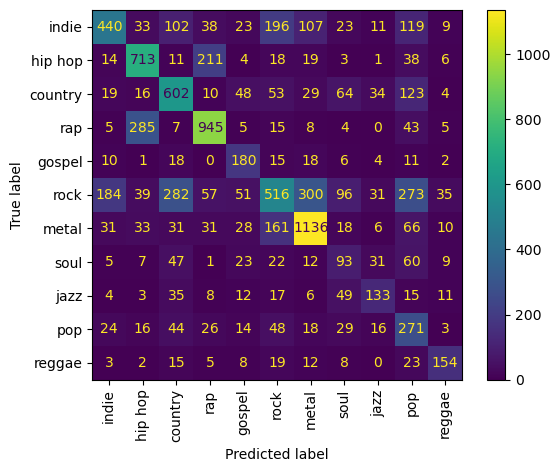

In [62]:
cm = confusion_matrix(combined_true, combined_pred, labels = true.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=true.unique())

# Plot
disp.plot()
plt.xticks(rotation=90)
plt.show()

| Technique            | Accuracy | Precision (weighted avg) | Recall (weighted avg) | F1-Score (weighted avg) |
|----------------------|----------|--------------------------|-----------------------|-------------------------|
| Baseline             | 13%      | 13%                      | 13%                   | 13%                     |
| Naive Bayes          | 55%      | 58%                      | 55%                   | 53%                     |
| Undersampling        | 49%      | 52%                      | 49%                   | 48%                     |
| Oversampling         | 55%      | 56%                      | 55%                   | 55%                     |
| Combined             | 55%      | 56%                      | 55%                   | 54%                     |

## Feature extraction

Performing feature extraction to see which features the model thinks are the most important for the different classes. We want to see if the model's decisions are affected by the distribution in the training data.

In [78]:
pipes = {'No sampling': pipe, 'Undersampled': undersampled_pipe, 'Oversampled': oversampled_pipe, 'Combined': combined_pipe}
for key, p in pipes.items():
    print(f"\n{key} strategy:\n ")
    
    classifier = p.named_steps['multinomialnb']
    vectorizer = p.named_steps['countvectorizer']
    
    # Extracting feature importance
    feature_log_prob = classifier.feature_log_prob_
    feature_names = vectorizer.get_feature_names_out()
    
    for i, class_label in enumerate(classifier.classes_):
        top_features_indices = np.argsort(feature_log_prob[i])[-5:]
        top_features = [feature_names[j] for j in top_features_indices]
        print(f"Top {len(top_features_indices)} words for class {class_label}: {top_features}")


No sampling strategy:
 
Top 5 words for class country: ['man', 'night', 'good', 'heart', 'time']
Top 5 words for class gospel: ['life', 'heart', 'jesus', 'lord', 'god']
Top 5 words for class hip hop: ['niggas', 'fuck', 'ya', 'shit', 'nigga']
Top 5 words for class indie: ['life', 'wanna', 'night', 'feel', 'time']
Top 5 words for class jazz: ['dream', 'night', 'time', 'day', 'heart']
Top 5 words for class metal: ['die', 'night', 'feel', 'life', 'time']
Top 5 words for class pop: ['heart', 'feel', 'girl', 'time', 'wanna']
Top 5 words for class rap: ['fuck', 'ya', 'niggas', 'shit', 'nigga']
Top 5 words for class reggae: ['people', 'time', 'dem', 'jah', 'man']
Top 5 words for class rock: ['night', 'life', 'heart', 'feel', 'time']
Top 5 words for class soul: ['good', 'day', 'night', 'heart', 'time']

Undersampled strategy:
 
Top 5 words for class country: ['night', 'heart', 'good', 'day', 'time']
Top 5 words for class gospel: ['life', 'jesus', 'heart', 'lord', 'god']
Top 5 words for class h

We can see that the model makes the same decisions no matter what the 